# Pneumonia Fighter

**Team Member: Changqi Xiao, Peihan Li and Yuxin Kan**

---
## Motivation
We want to precisely diagnose pneumonia by learning from chest X-rays of patients. Basically, we will use CNN combined with some innovations to achieve high accuracy (hopefully over 90%) of detecting pneumonia. Besides high accuracy, we also want to get a high AUC score for our classification.


## Innovation

First of all, we need to solve the problem that the validation set is relatively small. Here we need to introduce data augmentation to mitigate the problem of having a small dataset. We plan to apply a technique called “Pre-sizing”, and then we will augment further with Rotate and Zoom instead of flipping or warping or changing the brightness and contrast considering that in medical cases, these methods will not represent an actual X-ray image anymore.

Most importantly, we need to overcome the class imbalance of the data sets. After reading [this paper](https://arxiv.org/abs/1710.05381), we know that the most used approaches to overcome class imbalance are either downsampling (using less data) the class which has a higher ratio or oversampling the class which has a lower ratio. So we decide to apply the latter method, which means increasing the number of “normal” cases by simply repeating them in the training dataset.

<!-- Finally, after training ResNet as a baseline model, we plan to apply XResNets because it’s an improved ResNet by combining changes in data augmentations and optimization methods, which seems to fit our problem better. We plan to first train a model based on a pretrained XResNets model on normalized data, and then try to optimize the architecture, or apply cross-validation and model fusion. -->

## Social Impact

Pneumonia is an infection that inflames the air sacs in one or both lungs. The infection causes the lungs' air sacs to become inflamed and fill up with fluid or pus. That can make it hard for the oxygen you breathe in to get into your bloodstream. According to the CDC, In the United States, 1.5 million people were diagnosed with pneumonia in an emergency department during 2018. More than 40,000 people died from the disease that year in the United States. Obviously, pneumonia can do harm to the world and it is a must to restrict the spread of it. So it is crucial to find a way to diagnose pneumonia efficiently. Currently, there are two main methods to detect the bacteria. They are chest X-rays and blood tests. In this project, we will focus on how to diagnose pneumonia from chest X-rays of patients. Precisely diagnosing pneumonia is the premise of preventing its spread, which has a profound social impact.

---
## Data Analysis


### Dataset Overview



In [ ]:
# @title Install
!pip install --upgrade seaborn matplotlib

     |████████████████████████████████| 11.2 MB 4.0 MB/s 
     |████████████████████████████████| 900 kB 46.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# @title Import
import os
import time
import torch
import pathlib
import random
import glob
import numpy as np
import pandas as pd 
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
from IPython.display import HTML, display

from tqdm.notebook import tqdm, trange
from time import sleep
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.get_num_threads()

(device(type='cuda'), 1)


Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

***Root Path***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_path = '/content/drive/MyDrive/Colab Notebooks/chest_xray/'

***Datasets for Train, Validation and Test***

The [dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,856 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Another difficulty of handling the data is that the size of each image is not the same, so we have to cut the image reasonably to make them the same size without losing information.

In [ ]:
train_batch_size = 32
val_batch_size = 16
test_batch_size = 624
degrees = 90
train_dataset = ImageFolder(
    root = root_path + 'train/', transform = transforms.Compose([transforms.Resize((224,224)),
                                                                 transforms.RandomRotation(degrees, resample=False,expand=False, center=None),
                                                                 transforms.ToTensor()]))
val_dataset = ImageFolder(
    root = root_path + 'val/', transform = transforms.Compose([transforms.Resize((224,224)),
                                                               transforms.ToTensor()]))
test_dataset = ImageFolder(
    root = root_path + 'test/', transform = transforms.Compose([transforms.Resize((224,224)),
                                                                transforms.ToTensor()]))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


We can simply take a look at the image below.

In [ ]:
pneumonia = os.listdir(root_path + 'train/PNEUMONIA')
normal = os.listdir(root_path + 'train/NORMAL')

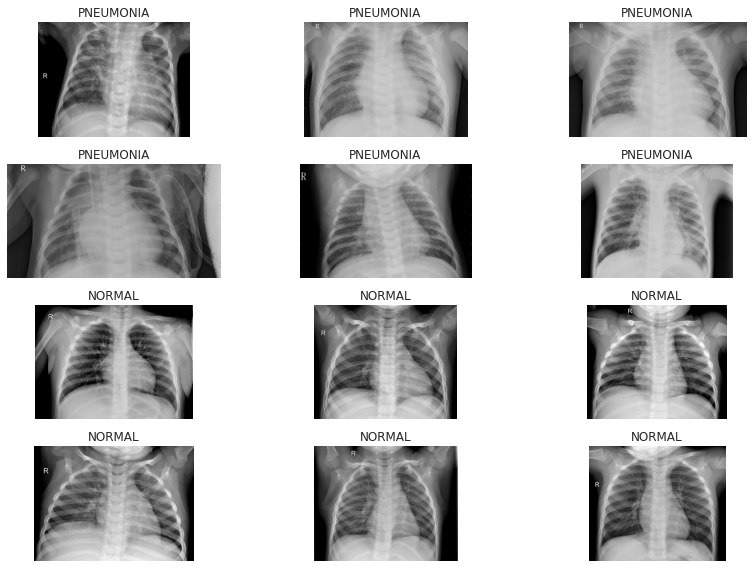

In [ ]:
# @title Images
plt.figure(figsize=(12, 8))

for i in range(6):
    plt.subplot(4, 3, i + 1)
    img = plt.imread(os.path.join(root_path + 'train/PNEUMONIA', pneumonia[i]))
    plt.title("PNEUMONIA")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
for i in range(6):
    plt.subplot(4, 3, i + 7)
    img = plt.imread(os.path.join(root_path + 'train/NORMAL', normal[i]))
    plt.title("NORMAL")
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

### Dataset Visualization###

Specifically, there are 5216, 16, 624 images in our training set, validation set, and test set respectively. 

In [ ]:
train_pneumonia = len(os.listdir(os.path.join(root_path + 'train/' 'PNEUMONIA')))
train_normal = len(os.listdir(os.path.join(root_path + 'train/', 'NORMAL')))

val_pneumonia = len(os.listdir(os.path.join(root_path + 'val/', 'PNEUMONIA')))
val_normal = len(os.listdir(os.path.join(root_path + 'val/', 'NORMAL')))

test_pneumonia = len(os.listdir(os.path.join(root_path + 'test/', 'PNEUMONIA')))
test_normal = len(os.listdir(os.path.join(root_path + 'test/', 'NORMAL')))

df = pd.DataFrame({'set': ['train', 'train', 'validation', 'validation', 'test', 'test'],
                   'class': ['pneumonia', 'normal', 'pneumonia', 'normal', 'pneumonia', 'normal'],
                   'count': [train_pneumonia, train_normal, val_pneumonia, val_normal, test_pneumonia, test_normal]})

df


,set,class,count
0,train,pneumonia,3875
1,train,normal,1341
2,validation,pneumonia,8
3,validation,normal,8
4,test,pneumonia,390
5,test,normal,234


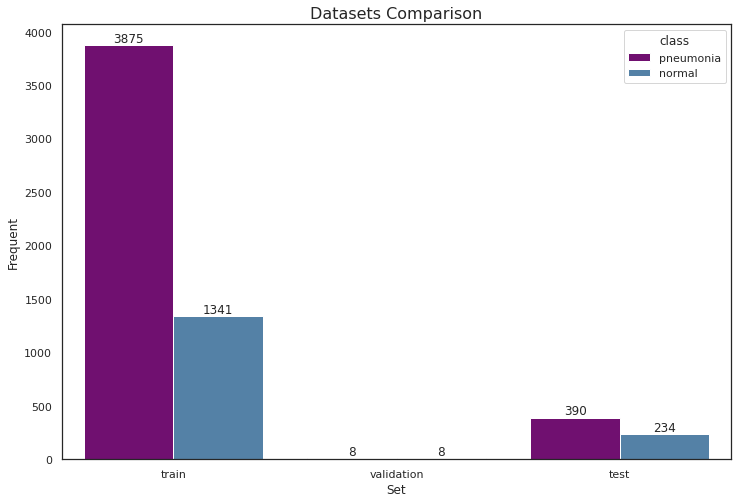

In [ ]:
# @title Datasets Comparison
plt.figure(figsize=(12,8))
sns.set(style='white')
ax = sns.barplot(x='set', y='count', hue='class', data=df, palette=['purple', 'steelblue'])
for container in ax.containers:
    ax.bar_label(container)
plt.title('Datasets Comparison', fontsize=16)
plt.xlabel('Set')
plt.ylabel('Frequent')
plt.show()

In [ ]:
pneumonia_train = glob.glob(root_path + '/train/PNEUMONIA/*.jpeg')
normal_train = glob.glob(root_path + '/train/NORMAL/*.jpeg')
data = pd.DataFrame(np.concatenate([['PNEUMONIA']*len(pneumonia_train), ['NORMAL']*len(normal_train)]),columns=["class"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


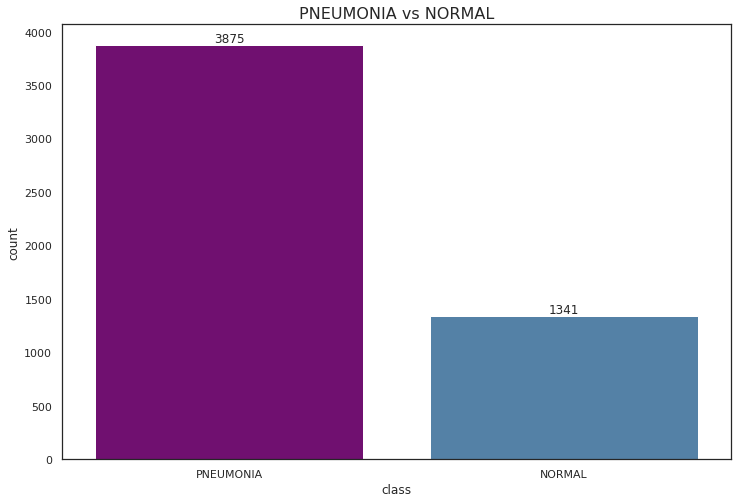

In [ ]:
# @title PNEUMONIA vs NORMAL
plt.figure(figsize=(12,8))
ax = sns.countplot(data['class'], data=data, palette=['purple', 'steelblue'])
for container in ax.containers:
    ax.bar_label(container)
plt.title('PNEUMONIA vs NORMAL', fontsize=16)
plt.show()

As for our training set, the ratio of pneumonia samples to normal samples is about 2.89. It is hard for our eyes to make the classification. 

One of the challenges of this dataset is class imbalance. Around 74% of images are labeled as Pneumonia and 26% are normal. We need to take care of this problem using algorithms based on data augmentation.

## Implementations

###Data loaders###

Data loaders create data batches and perform transformations on the images. 

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = val_batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = test_batch_size, shuffle = False)

print("Train Dataset:\n",train_dataset)
print("Val Dataset:\n",val_dataset)
print("Test Dataset:\n",test_dataset)

Train Dataset:
 Dataset ImageFolder
    Number of datapoints: 5216
    Root location: /content/drive/MyDrive/Colab Notebooks/chest_xray/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )
Val Dataset:
 Dataset ImageFolder
    Number of datapoints: 16
    Root location: /content/drive/MyDrive/Colab Notebooks/chest_xray/val/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
Test Dataset:
 Dataset ImageFolder
    Number of datapoints: 624
    Root location: /content/drive/MyDrive/Colab Notebooks/chest_xray/test/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=No

### Helper Function

In [ ]:
class LRScheduler():
    """
    Learning rate scheduler. If the validation loss does not decrease for the 
    given number of `patience` epochs, then the learning rate will decrease by
    by given `factor`.
    """
    def __init__(
        self, optimizer, patience=5, min_lr=1e-6, factor=0.5
    ):
        """
        new_lr = old_lr * factor

        :param optimizer: the optimizer we are using
        :param patience: how many epochs to wait before updating the lr
        :param min_lr: least lr value to reduce to while updating
        :param factor: factor by which the lr should be updated
        """
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor

        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
                self.optimizer,
                mode='min',
                patience=self.patience,
                factor=self.factor,
                min_lr=self.min_lr,
                verbose=True
            )

    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

###Train###

In [ ]:
def train(model, criterion, optimizer, device, train_loader, validation_loader, epochs, 
          lr_scheduler, early_stopping, lr_scheduler_flag=False, early_stopping_flag=False):
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.

        correct, total = 0, 0 
        with tqdm(train_loader, unit='batch') as tepoch:
            tepoch.set_description('Training: ')
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)
                output = model(data)
                optimizer.zero_grad()
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                
                tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()
                
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
                
        train_loss.append(running_loss / len(train_loader))  # append the loss for this epoch
        train_acc.append(correct/total)
                
        # evaluate on validation data
        
        model.eval()
        running_loss = 0.
        correct, total = 0, 0 
        with tqdm(validation_loader, unit='batch') as tepoch:
            tepoch.set_description('Validation: ')
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                loss = criterion(output, target)
                tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()

                # get accuracy 
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        validation_loss.append(running_loss/len(validation_loader))
        validation_acc.append(correct/total)
        
        if validation_acc[-1] == 1: break
        if lr_scheduler_flag:
            lr_scheduler(validation_loss[-1])
        if early_stopping_flag:
            early_stopping(validation_loss[-1])
            if early_stopping.early_stop:
                break
    
    return train_loss, train_acc, validation_loss, validation_acc 

###Test###

In [ ]:
def test(model, device, data_loader):

    model.eval()
    correct = 0
    total = 0
    for data in data_loader:
        inputs, labels = data

        inputs = inputs.to(device).float()
        labels = labels.to(device).long()

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return acc

###Plot

In [ ]:
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.title('EVALUATION OF AlexNet')
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()

###Confusion Matrix

Create the confusion matrix and save it as pandas dataframe confusion_matrix_df

In [ ]:
def get_y(net, test_loader):
    y_pred=torch.zeros(0,dtype=torch.long, device='cpu')
    y_true=torch.zeros(0,dtype=torch.long, device='cpu')
    with torch.no_grad():
      for batch in test_loader:
        data, label = batch
        data, label = data.to(device), label.to(device)
        outputs = net(data)
        _, preds = torch.max(outputs, 1)
        y_pred = torch.cat([y_pred, preds.view(-1).cpu()])
        y_true = torch.cat([y_true, label.view(-1).cpu()])

    return y_pred, y_true

In [ ]:
def create_confusion_matrix(net, test_loader):
  y_pred, y_true = get_y(net, test_loader)
  confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, y_pred))
  return confusion_matrix_df

In [ ]:
def plot_confusion_matrix(confusion_matrix_df):
  plt.figure(figsize=(16,8))
  sns.heatmap(confusion_matrix_df, cmap="RdBu", annot=True)
  plt.title('Alexnet Confusion Matrix Heatmap', fontsize=16)
  plt.xlabel("Predicted condition")
  plt.ylabel("Actual condition")
  plt.show()

We can see that since our CNN model have relatively high accuracy, lots of diagonal elements have high values.

However, if we look closely, there are still false poitive and false negative cases. This means that the trained CNN model was unable to correctly classify any of the data with those labels. The model can be improved.

From here we might be able to figure out some potential reasons for this and make changes to the model architecture.

##Models and Experiment Results##

###KNN###

+ Accuracy: 0.77
+ Precision: 0.73
+ Recall: 0.99
+ F-Score: 0.84

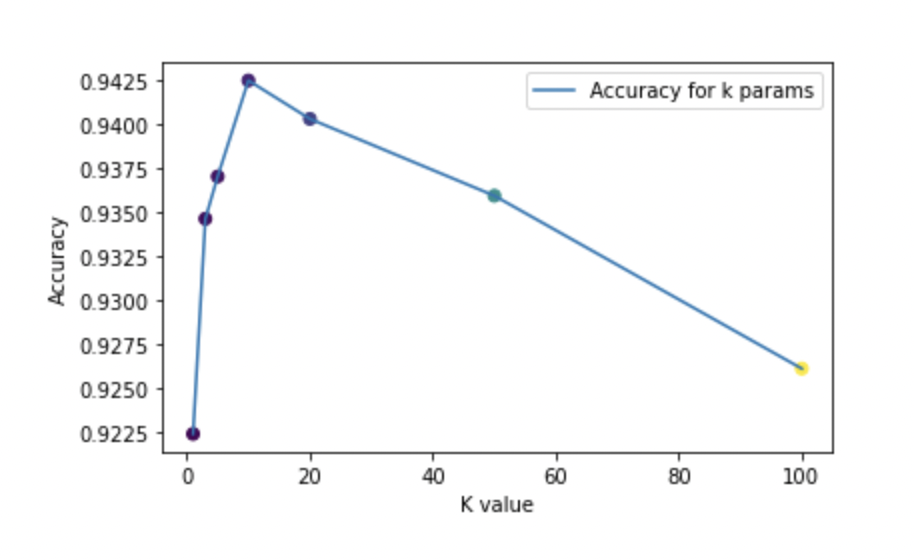

In [ ]:
from IPython.display import Image
Image('/content/Screen Shot 2022-04-18 at 7.56.58 PM.png', width=600)

From the plot above, we choose k = 10

In [ ]:
from IPython.display import Image
Image('/content/knn_confusion_matrix(1).png', width=1300)

###Logistic Regression###

+ Accuracy: 0.78
+ Precision: 0.74
+ Recall: 0.98
+ F-Score: 0.84

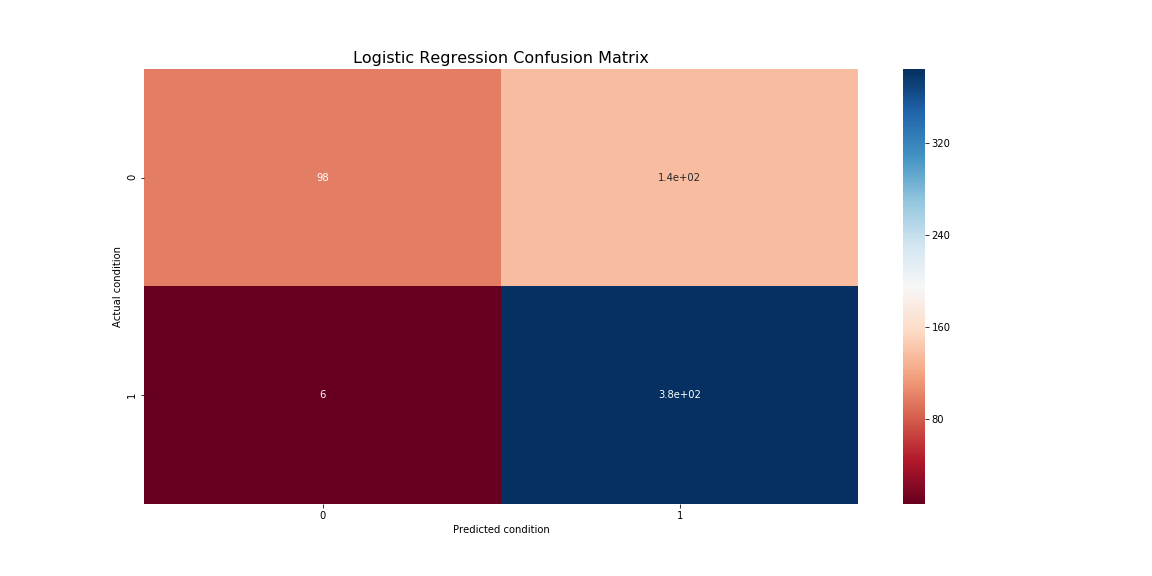

In [ ]:
from IPython.display import Image
Image('/content/log_regression_confusion_matrix.png', width=1300)

###Basic CNN###

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.fc1 = nn.Linear(in_features=387200, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=2)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)
    x = x.flatten(start_dim=1)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

cnn_net = CNN().to(device)
cnn_optimizer = torch.optim.Adam(cnn_net.parameters(), lr=1e-5)
num_epochs = 20

+ Accuracy: 0.7772436141967773
+ Precision: 0.7455968688845401
+ Recall: 0.9769230769230769
+ F-Score: 0.8457269700332964

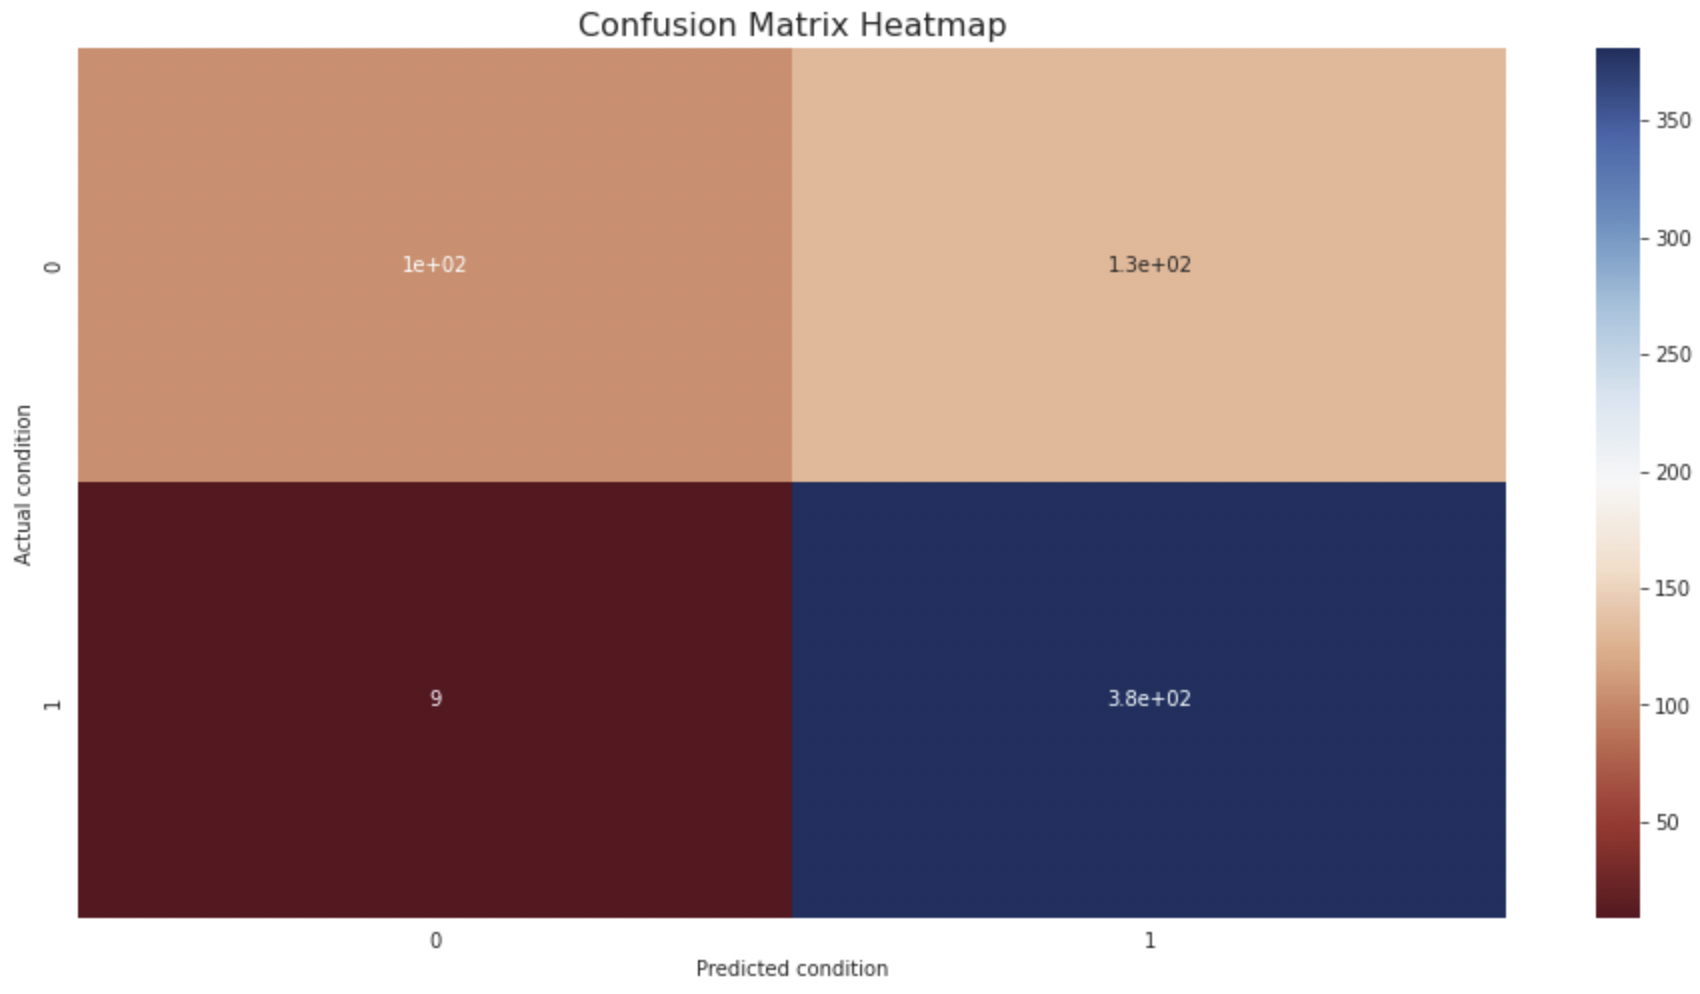

In [ ]:
#@title Confusion Matrix
!wget https://b2.cdn.dov.moe/2022/04/18/559b7f1c-d4c7-4662-8b06-64b3581046e6.png -O basic_cnn_confusion_matrix.png -o /dev/null
from IPython.display import Image
Image('basic_cnn_confusion_matrix.png', width=800)

###Alexnet###

In [ ]:
net = models.alexnet(pretrained=True)
net.fc = nn.Linear(512, 2)
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available(): 
  net.cuda()
  criterion = criterion.cuda()
optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-5)
num_epochs = 15

+ Accuracy: 0.9086538461538461

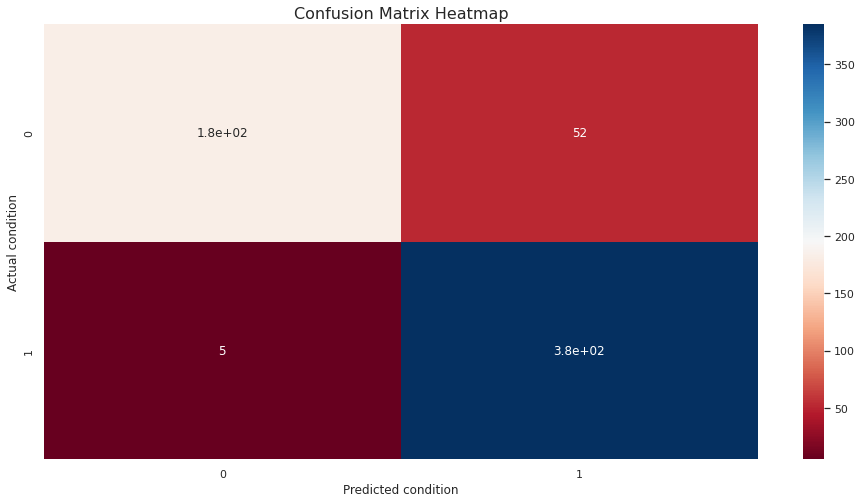

In [ ]:
from IPython.display import Image
Image('/Alexnet Confusion Matrix.png', width=800)

###VGG19###

In [ ]:
vgg_model = models.vgg19(pretrained=True)
for param in vgg_model.parameters():
  param.requires_grad = False

for param in vgg_model.classifier.parameters():
    param.requires_grad = True

num_ftrs = vgg_model.classifier[-1].in_features

vgg_model.classifier[-1] = nn.Sequential(
    nn.Linear(num_ftrs, 2)
)
vgg_model = vgg_model.to(device)
optimizer = torch.optim.Adam(vgg_model.parameters(), lr=1e-5)
num_epochs = 20
print(vgg_model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

+ Accuracy: 0.8717948794364929
+ Precision: 0.84375
+ Recall: 0.9692307692307692
+ F-Score: 0.9021479713603818

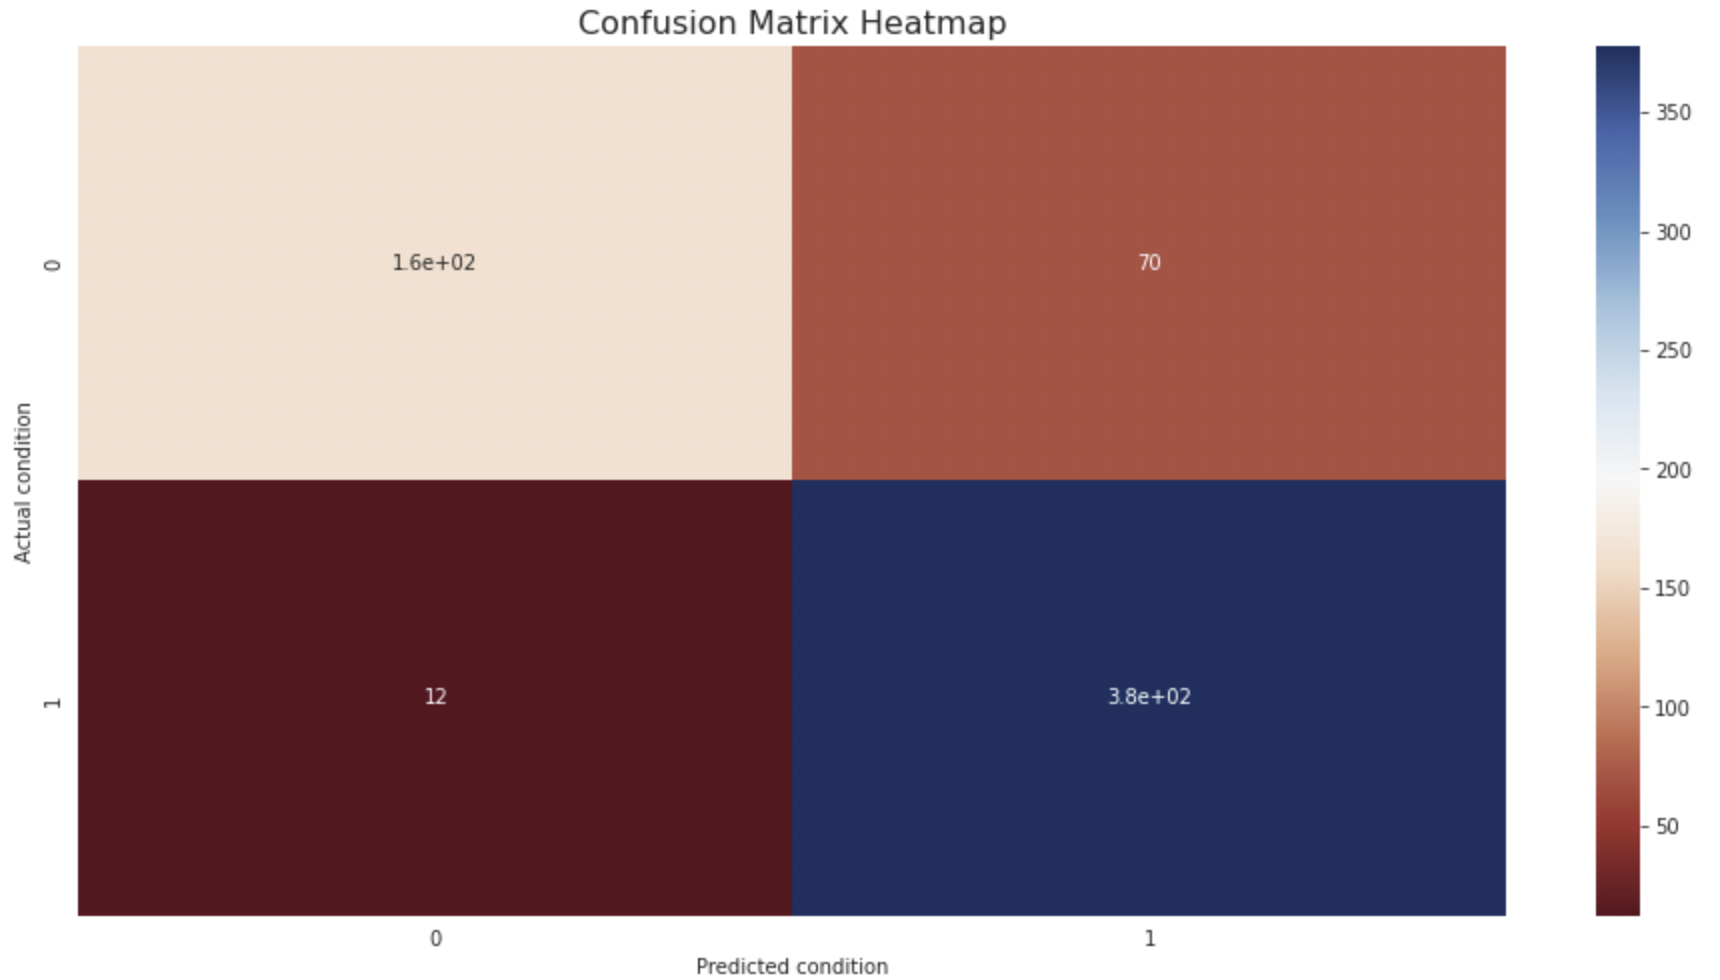

In [ ]:
#@title Confusion Matrix
!wget https://b2.cdn.dov.moe/2022/04/18/2501cb62-5b75-460c-89c0-c7b48de8b029.png -O vgg19_confusion_matrix.png -o /dev/null
from IPython.display import Image
Image('vgg19_confusion_matrix.png', width=800)

### Resnet###

In [ ]:
class Resnet():
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Freeze training for all layers before classifier
        for param in self.network.fc.parameters():
            param.require_grad = False  
        num_features = self.network.fc.in_features # get number of in features of last layer
        self.network.fc = nn.Linear(num_features, 2) # replace model classifier
    
    def forward(self, xb):
        return self.network(xb)

<class '__main__.Resnet'>


+ Accuracy: 0.90
+ Precision: 0.99
+ Recall: 0.85
+ F-Score: 0.92

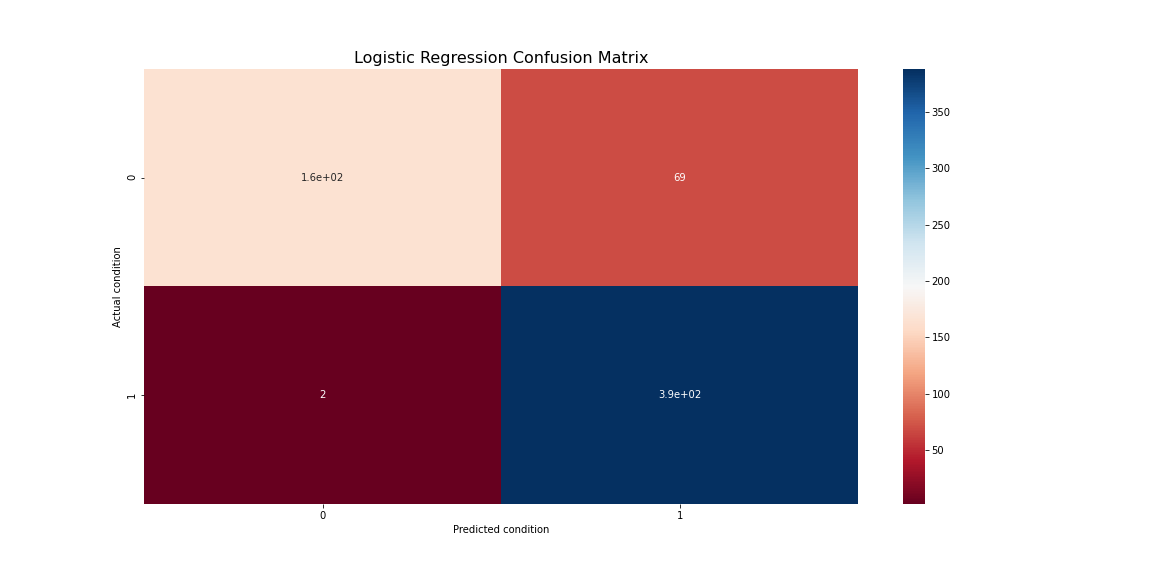

In [ ]:
from IPython.display import Image
Image('/content/resnet_confusion_matrix.png', width=1300)

## Conclusion

Above all, both finetuned Alexnet models and Resnet models can achieve accuracies of more than 90% and Resnet has best performance.